In [1]:
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.patches
import time
from matplotlib.ticker import MaxNLocator
import os, sys
from astropy.io import fits
from astropy.stats import sigma_clip
from photutils import aperture_photometry
from photutils import CircularAperture
from numpy import std
import glob
import csv
import operator
import matplotlib.ticker as mtick
from photutils.datasets import make_4gaussians_image
#from photutils.morphology import (centroid_com,centroid_1dg,centroid_2dg)
from time import time
#from scipy.linalg.fblas import dgemm
from astropy.convolution import convolve, Box1DKernel
import collections
from astropy.convolution import Gaussian1DKernel

import astropy.constants as constants
import astropy.units as units

import os, sys

%matplotlib inline

In [2]:
'''Hard Coded'''

user = 'Taylor'
planet = 'WASP-12b_old'
channel = 'ch1'

if planet == 'WASP-12b':
    AOR_snip = '4801'
else:
    if channel == 'ch2':
        AOR_snip = '4158'
    else:
        AOR_snip = '4126'

basepath = '/home/taylor/Documents/Research/spitzer/'+planet+'/analysis/'

datapath = basepath+channel+'/'
figpath = basepath+'photometryComparison/'

trim = False
trimStart = 5.5544266e4
trimEnd = 5.554285e4

highpassWidth = 50

# Everything below should be made completely automatic

In [3]:
'''Get list of directories'''
def get_fnames(directory, tag='Run'):
    '''
    Find paths to all the fits files.

    Parameters
    ----------

    directory : string object
        Path to the directory containing all the Spitzer data.

    AOR_snip  : string object
        Common first characters of data directory eg. 'r579'

    ch        : string objects
        Channel used for the observation eg. 'ch1' for channel 1    

    Returns
    -------

    fname     : list
        List of paths to all bcd.fits files.

    len(fnames): int
        Number of fits file found.
    '''
    lst      = os.listdir(directory)
    Run_list = [k for k in lst if tag in k]
    return sorted(Run_list)

In [4]:
if user == 'Taylor':
    tag = 'um'
    Run_list = get_fnames(datapath, tag)
else:
    Run_list = get_fnames(datapath)

Radius = np.array([float(Run_list[i].split('_')[0][-1] + '.' + Run_list[i].split('_')[-1][:]) for i in range(len(Run_list))])
    
Run_list = [datapath + st for st in Run_list]

In [5]:
def get_full_data(foldername, channel, AOR_snip):
    path = foldername + '/'+channel+'_datacube_full_AORs'+AOR_snip+'.dat'
    flux     = np.loadtxt(path, usecols=[0], skiprows=1)     # Flux from circular aperture (MJy/str)
    time     = np.loadtxt(path, usecols=[2], skiprows=1)     # time in days?
    xdata    = np.loadtxt(path, usecols=[3], skiprows=1)     # x-centroid (15 = center of 15th pixel)
    ydata    = np.loadtxt(path, usecols=[4], skiprows=1)     # y-centroid (15 = center of 15th pixel)
    psfwx    = np.loadtxt(path, usecols=[5], skiprows=1)     # psf width in pixel size (FWHM of 2D Gaussian)
    psfwy    = np.loadtxt(path, usecols=[6], skiprows=1)     # psf width in pixel size (FWHM of 2D Gaussian)    
    return flux, time, xdata, ydata, psfwx, psfwy

In [6]:
def get_data(folderdata, channel, AOR_snip):
    path = folderdata + '/'+channel+'_datacube_binned_AORs'+AOR_snip+'.dat'
    path2= folderdata + '/popt.dat'
    
    #Loading Data (Aperture)
    flux     = np.loadtxt(path, usecols=[0], skiprows=1)     # Flux from circular aperture (MJy/str)
    flux_err = np.loadtxt(path, usecols=[1], skiprows=1)     # Flux uncertainty from circular aperture (MJy/str)
    time     = np.loadtxt(path, usecols=[2], skiprows=1)     # Time in days
    xdata    = np.loadtxt(path, usecols=[4], skiprows=1)     # x-centroid (15 = center of 15th pixel)
    ydata    = np.loadtxt(path, usecols=[6], skiprows=1)     # y-centroid (15 = center of 15th pixel)
    psfwx    = np.loadtxt(path, usecols=[8], skiprows=1)     # psf width in pixel size (FWHM of 2D Gaussian)
    psfwy    = np.loadtxt(path, usecols=[10], skiprows=1)    # psf width in pixel size (FWHM of 2D Gaussian)
    
    return flux, flux_err, time, xdata, ydata, psfwx, psfwy 

In [7]:
def highpassflist(signal, highpassWidth):
    #g = Gaussian1DKernel(stddev=10)
    g = Box1DKernel(highpassWidth)
    smooth=convolve(np.asarray(signal), g,boundary='extend')
    return smooth

In [8]:
def get_RMS(Run_list, channel, AOR_snip, highpassWidth, trim=False, trimStart=0, trimEnd=0):
    RMS_list = np.empty(len(Run_list))
    for i in range(len(Run_list)):
        foldername = Run_list[i]
        flux, flux_err, time, xdata, ydata, psfwx, psfwy = get_data(foldername, channel, AOR_snip)
        if trim:
            flux = np.delete(flux, np.where(np.logical_and(time > trimStart, time < trimEnd))[0])
            time = np.delete(time, np.where(np.logical_and(time > trimStart, time < trimEnd))[0])
            
        order = np.argsort(time)
        flux = flux[order]
        time = time[order]
            
        smooth = highpassflist(flux, highpassWidth)
        smoothed = (flux - smooth)+np.mean(flux)
        RMS_list[i] = np.sqrt(np.mean((flux-smooth)**2.))/np.mean(smoothed)
        path = foldername + '/RMS_Scatter.pdf'
        fig, axes = plt.subplots(ncols = 1, nrows = 2, sharex = True, figsize = (10,6))
        fig.suptitle('RMS = '+ str(RMS_list[i]))
        axes[0].plot(time, flux, 'k.', alpha = 0.15, label='Measured Flux')
        axes[0].plot(time, smooth, '+', label = 'Filtered')
        axes[0].set_ylabel('Relative Flux')
        axes[1].plot(time, (smoothed/np.mean(smoothed)-1)*1e2, 'k.', alpha =0.1)
        axes[1].set_xlim(np.min(time), np.max(time))
        axes[1].axhline(y=0, color='b', linewidth = 1)
        axes[1].set_ylabel('Residual (%)')
        axes[1].set_xlabel('Time since IRAC turn on(days)')
        fig.subplots_adjust(hspace=0)
        fig.savefig(path)
        plt.show()
        plt.close()
    return RMS_list

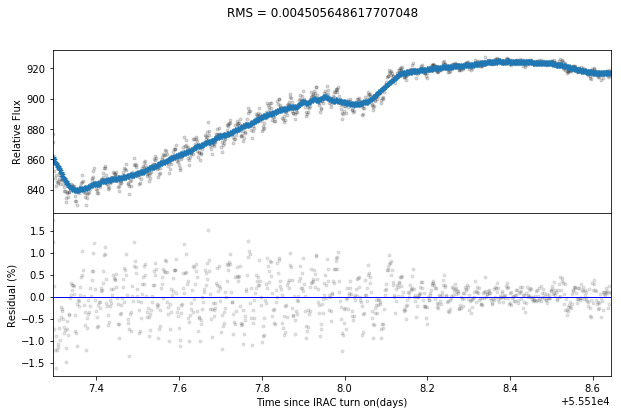

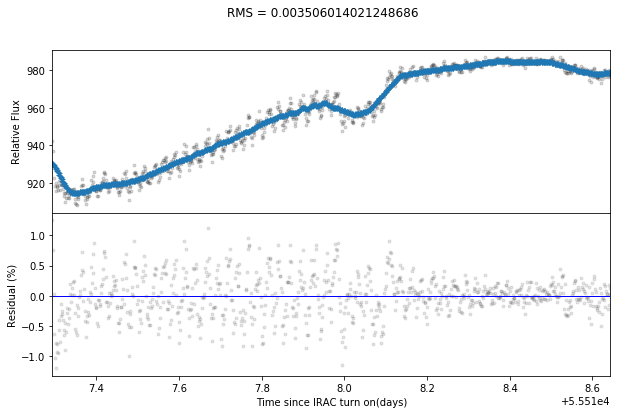

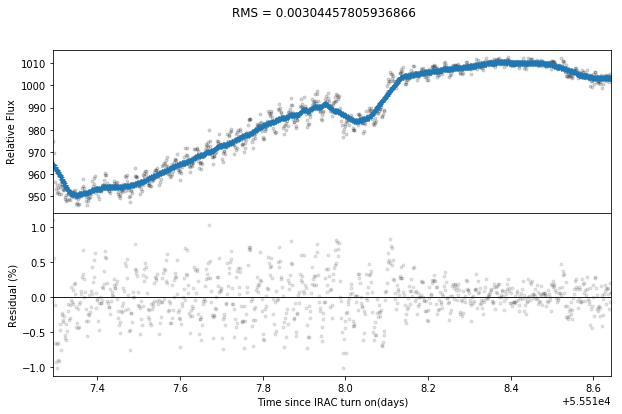

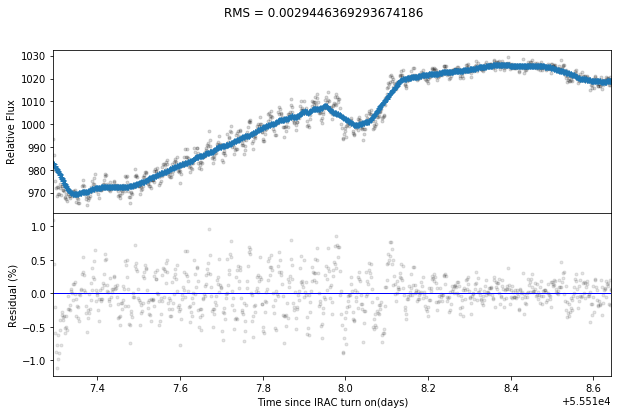

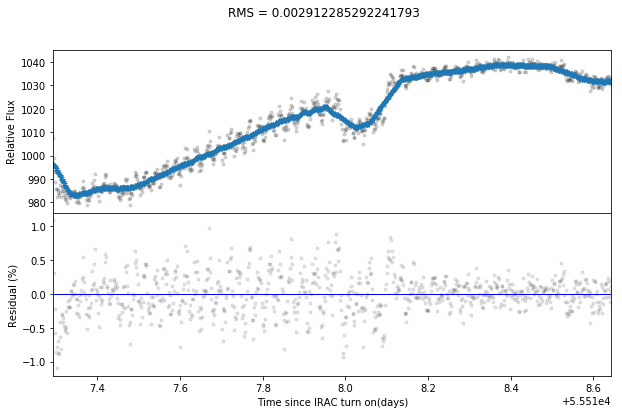

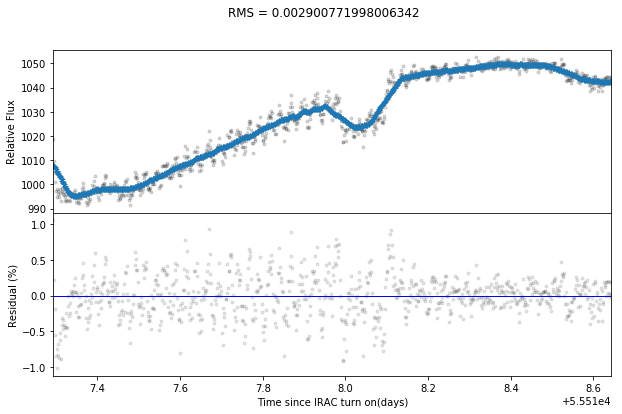

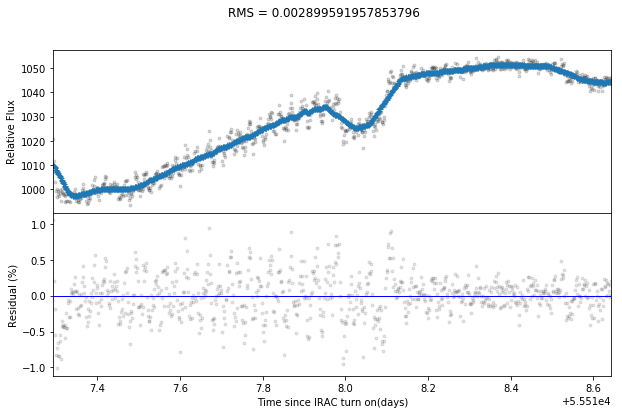

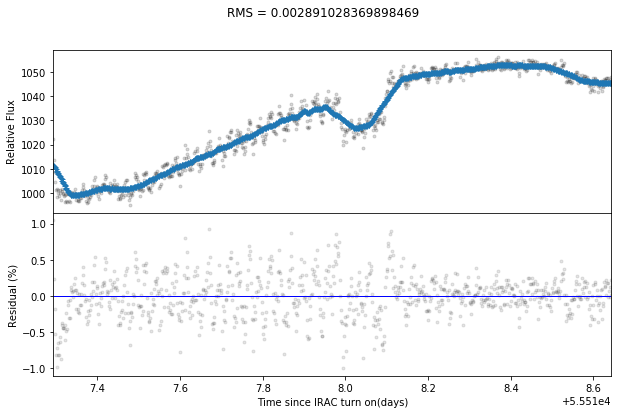

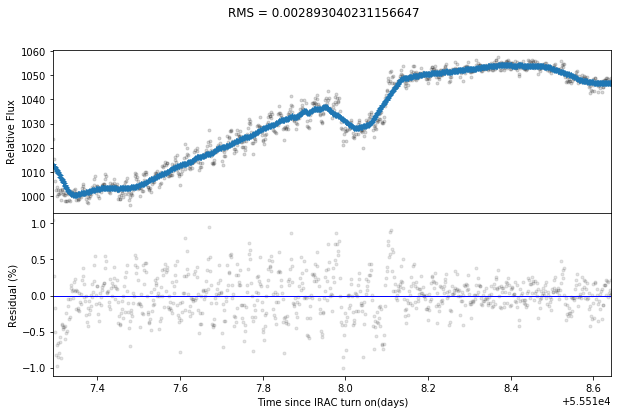

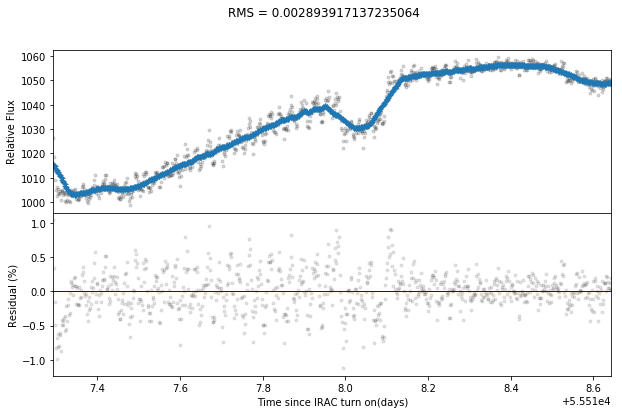

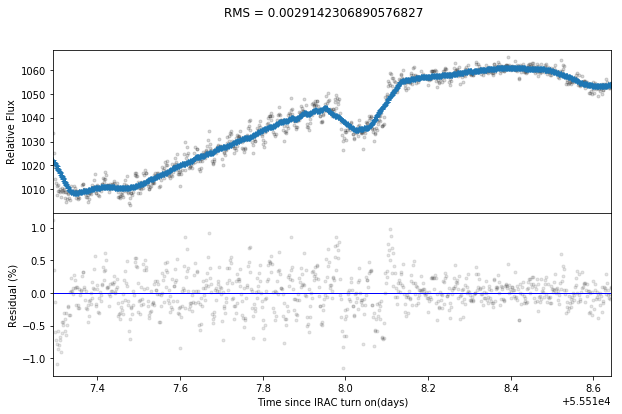

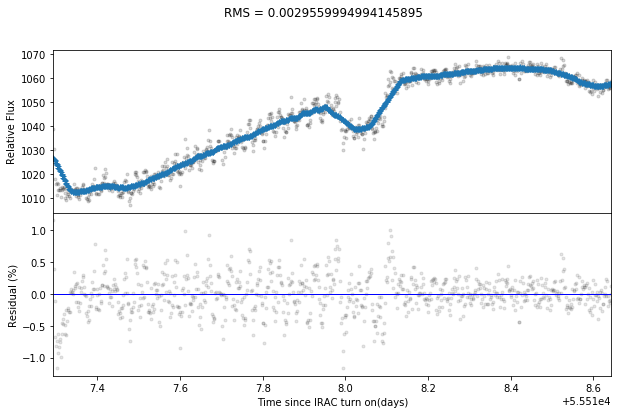

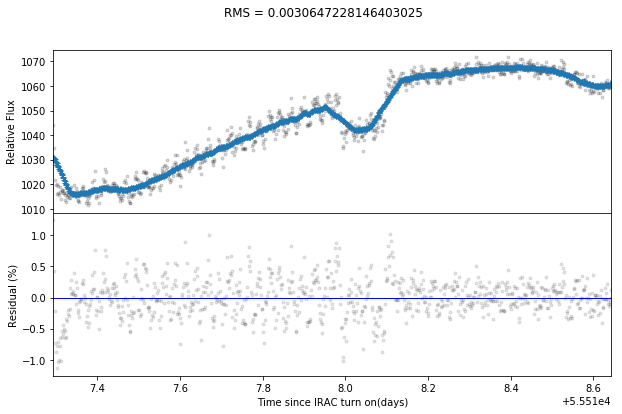

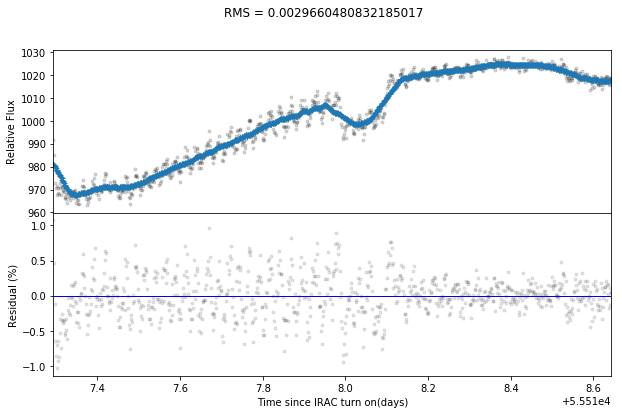

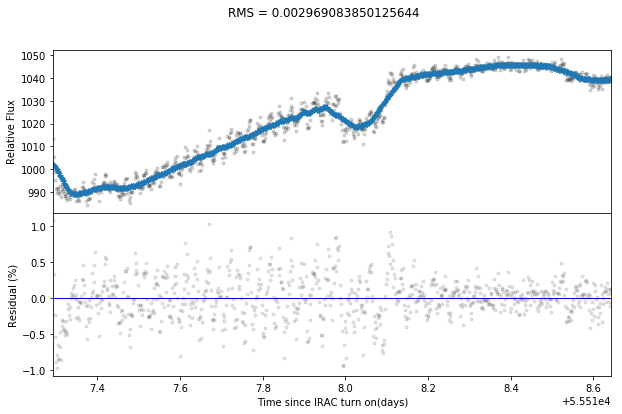

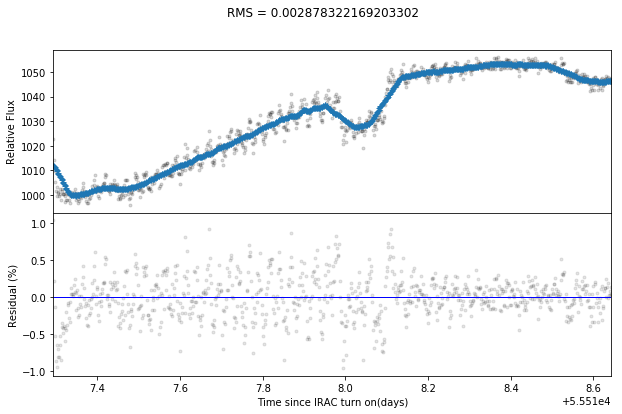

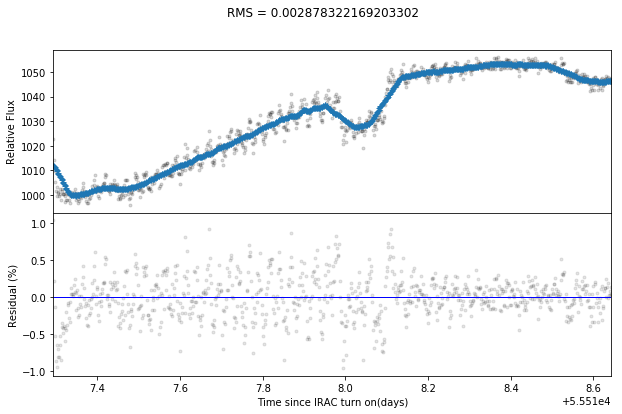

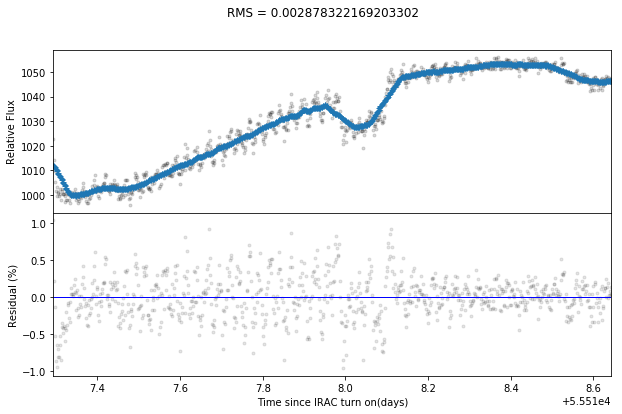

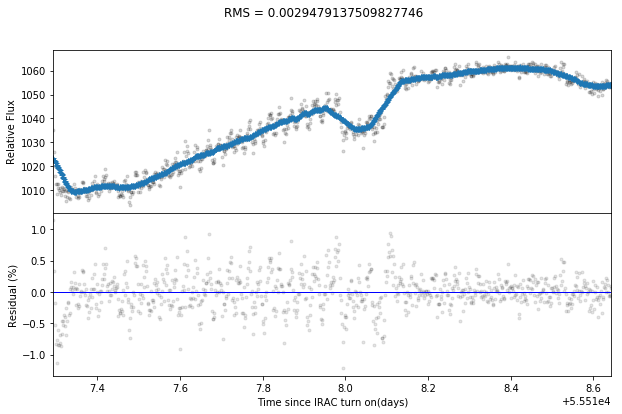

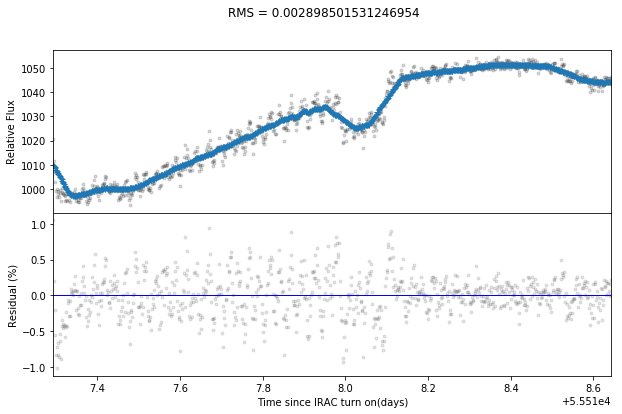

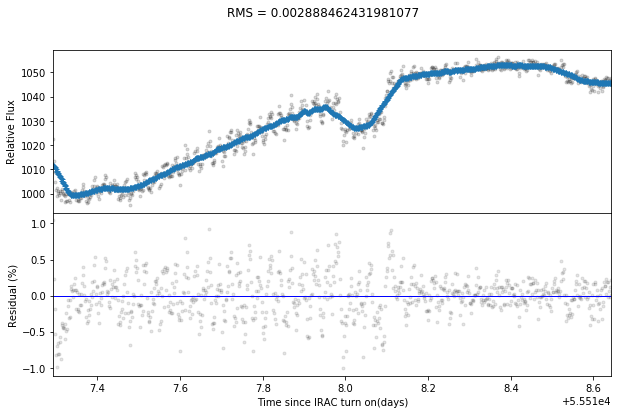

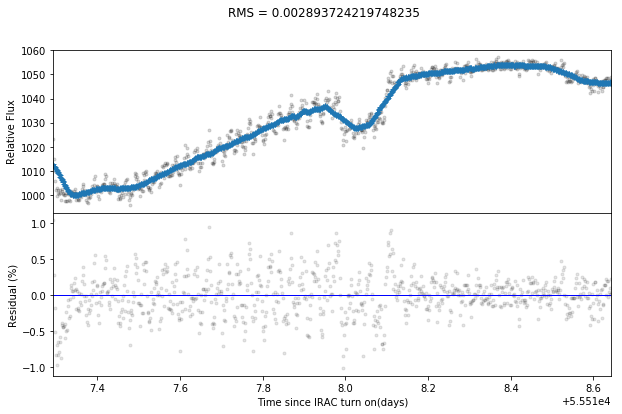

In [9]:
if trim:
    RMS = get_RMS(Run_list, channel, AOR_snip, highpassWidth, trim, trimStart, trimEnd)
else:
    RMS = get_RMS(Run_list, channel, AOR_snip, highpassWidth)

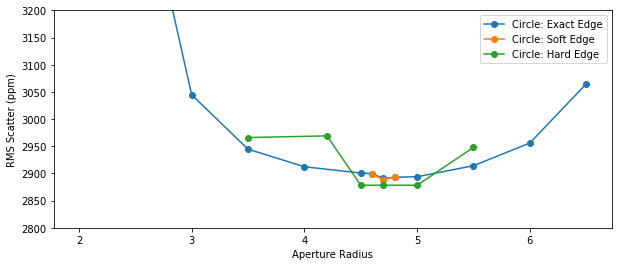

In [10]:
plt.figure(figsize = (10,4))

exact = np.array(['exact' in Run_list[i].lower() for i in range(len(Run_list))], dtype=bool)
soft =  np.array(['soft' in Run_list[i].lower() for i in range(len(Run_list))], dtype=bool)
hard =  np.array(['hard' in Run_list[i].lower() for i in range(len(Run_list))], dtype=bool)

if np.any(exact):
    plt.plot(Radius[exact],  RMS[exact]*1e6, 'o-', label = 'Circle: Exact Edge')
if np.any(soft):
    plt.plot(Radius[soft],  RMS[soft]*1e6, 'o-', label = 'Circle: Soft Edge')
if np.any(hard):
    plt.plot(Radius[hard],  RMS[hard]*1e6, 'o-', label = 'Circle: Hard Edge')
#plt.axhline(y=1.39485316958, color='orange', linewidth = 1, label = 'PSF Fitting')
#plt.axhline(y=RMS45, color='orange', linewidth = 1)
plt.xlabel('Aperture Radius')
plt.ylabel('RMS Scatter (ppm)')
#plt.ylim(ymin=0)
plt.legend(loc='best')

#plt.ylim(1900,2200)
#plt.ylim(2500,3500)
#plt.ylim(1650,1750)
plt.ylim(2800,3200)
if channel=='ch2':
    fname = figpath + '4um'
else:
    fname = figpath + '3um'
fname += '_Photometry_Comparison.pdf'
plt.savefig(fname)

In [11]:
if np.any(exact):
    print('Exact - Best RMS (ppm):', np.round(np.min(RMS[exact])*1e6, decimals=2))
    print('Exact - Best Aperture Radius:', Radius[exact][np.where(RMS[exact]==np.min(RMS[exact]))[0][0]])
    print()
if np.any(soft):
    print('Soft - Best RMS (ppm):', np.round(np.min(RMS[soft])*1e6, decimals=2))
    print('Soft - Best Aperture Radius:', Radius[soft][np.where(RMS[soft]==np.min(RMS[soft]))[0][0]])
    print()
if np.any(hard):
    print('Hard - Best RMS (ppm):', np.round(np.min(RMS[hard])*1e6, decimals=2))
    print('Hard - Best Aperture Radius:', Radius[hard][np.where(RMS[hard]==np.min(RMS[hard]))[0][0]])

Exact - Best RMS (ppm): 2891.03
Exact - Best Aperture Radius: 4.7

Soft - Best RMS (ppm): 2888.46
Soft - Best Aperture Radius: 4.7

Hard - Best RMS (ppm): 2878.32
Hard - Best Aperture Radius: 4.5


In [12]:
if np.any(exact):
    print('Exact:', np.round(RMS[exact]*1e6, decimals=2))
    print()
if np.any(soft):
    print('Soft:', np.round(RMS[soft]*1e6, decimals=2))
    print()
if np.any(hard):
    print('Hard:', np.round(RMS[hard]*1e6, decimals=2))

Exact: [4505.65 3506.01 3044.58 2944.64 2912.29 2900.77 2899.59 2891.03 2893.04
 2893.92 2914.23 2956.   3064.72]

Soft: [2898.5  2888.46 2893.72]

Hard: [2966.05 2969.08 2878.32 2878.32 2878.32 2947.91]
